# PPO for Acrobot env

## import required libraries

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np

## Setting of Hyper parameters
learning_rates are shared both actor and critic
gamma is decaying rate for TD step
Both gamma and lambda are used for estimating GAE
T_horizon is time step, which means how long does current policy act before update

In [ ]:
learning_rate = 0.0005
gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20

## check availability of using cuda
torch.cuda.is_available()

In [5]:
cuda = torch.device('cuda')

## Model Structure

### Actor Class
Actor input : num of states
Actor output : probability logit(Categorical Distribution for discrete action space)
softmax dimension is 0 when predict just one step action,
but should be 1 when predict with batch in training phase

In [7]:
class Actor(nn.Module):
    def __init__(self, n_states, n_actions):
        super(Actor, self).__init__()
        
        self.fc1 = nn.Linear(n_states, 256)
        self.fc2 = nn.Linear(256, n_actions)

    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        prob = F.softmax(x, dim = softmax_dim)
        return prob

### Critic Class
Critic input : num of states
Critic output : state-value function

In [8]:
class Critic(nn.Module):
    def __init__(self, n_states):
        super(Critic, self).__init__()
        
        self.fc1 = nn.Linear(n_states, 256)
        self.fc2 = nn.Linear(256, 1)
      
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc2(x)
        return v

### PPO Class
initialize actor, critic, buffer
buffer is not ReplayBuffer like DQN, DDPG
PPO is on-policy actor-critic algorithm, so if the t-step size batch was used for updating current policy, then it should be removed

In [72]:
class PPO(object):
    def __init__(self,n_states, n_actions):
        self.actor = Actor(n_states,n_actions)
        self.critic = Critic(n_states)
        self.buffer = []
        
        self.actor = self.actor.to(device = cuda)
        self.critic = self.critic.to(device = cuda)
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr = learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr = learning_rate)
        
    def add(self, experience):
        self.buffer.append(experience)
    
    def batch_out(self):
        s_batch, a_batch, r_batch, s2_batch, prob_batch, t_batch = [],[],[],[],[],[]
        for experience in self.buffer:
            s, a, r, s2, prob_a, t = experience
            
            s_batch.append(s)
            a_batch.append([a])
            r_batch.append([r])
            s2_batch.append(s2)
            prob_batch.append([prob_a])
            t = (t == False) *1
            t_batch.append([t])
        
        s_batch = torch.tensor(s_batch, dtype = torch.float, device = cuda)
        a_batch = torch.tensor(a_batch, device = cuda)
        r_batch = torch.tensor(r_batch, dtype = torch.float, device = cuda)
        s2_batch = torch.tensor(s2_batch, dtype = torch.float, device = cuda)
        prob_batch = torch.tensor(prob_batch, dtype = torch.float, device = cuda)
        t_batch = torch.tensor(t_batch, dtype = torch.float, device = cuda)
        
        self.buffer = []
        return s_batch, a_batch, r_batch, s2_batch, prob_batch, t_batch
    
    def train(self):
        s_batch, a_batch, r_batch, s2_batch, prob_batch, t_batch = self.batch_out()
        
        for i in range(K_epoch):
            td_target = r + gamma * self.critic.v(s2_batch) * t_batch #(batch, 1)
            delta = td_target - self.critic.v(s_batch) #(batch, 1) tensor
            delta = delta.detach().cpu().numpy() #(batch, 1) np
            
            advantage_list = []
            advantage = 0.0
            
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_list.append([advantage])
            advantage_list.reverse()
            advantage = torch.tensor(advantage_list, dtype = torch.float, device = cuda) #(batch, 1) cuda tensor
            
            pi_new_logit = self.actor.pi(s_batch, softmax_dim = 1)
            pi_new = pi_new_logit.gather(1, a_batch)
            ratio = torch.exp(torch.log(pi_new)-torch.log(prob_batch))
            
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            actor_loss = - torch.min(surr1, surr2).mean()
            critic_loss = F.smooth_l1_loss(self.critic.v(s_batch), td_target.detach())
            
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

## Main Loop

In [73]:
env = gym.make('Acrobot-v1')

n_states = env.observation_space.shape[0]
n_actions = env.action_space.n

model = PPO(n_states, n_actions)
score_list = []

for n_ep in range(1000):
    score = 0.0
    s = env.reset()
    done = False
    while not done:
        #env.render()
        for t in range(T_horizon):
            s_cuda = torch.tensor(s, dtype = torch.float, device = cuda)
            
            prob_cuda = model.actor.pi(s_cuda)
            prob = prob_cuda.cpu()
            
            m = Categorical(prob)
            a = m.sample().item()
            s2, r, done, info = env.step(a)
            
            model.add((s, a, r, s2, prob[a].item(), done))
            s = s2
            
            score += r
            if done:
                break
    
        model.train()
    score_list.append(score)
    print("episode {} :score {}".format(n_ep, score))
env.close()

episode 0 :score -334.0
episode 1 :score -131.0
episode 2 :score -161.0
episode 3 :score -145.0
episode 4 :score -179.0
episode 5 :score -193.0
episode 6 :score -183.0
episode 7 :score -158.0
episode 8 :score -115.0
episode 9 :score -161.0
episode 10 :score -122.0
episode 11 :score -144.0
episode 12 :score -118.0
episode 13 :score -96.0
episode 14 :score -109.0
episode 15 :score -145.0
episode 16 :score -135.0
episode 17 :score -135.0
episode 18 :score -97.0
episode 19 :score -115.0
episode 20 :score -80.0
episode 21 :score -88.0
episode 22 :score -125.0
episode 23 :score -120.0
episode 24 :score -115.0
episode 25 :score -99.0
episode 26 :score -115.0
episode 27 :score -85.0
episode 28 :score -118.0
episode 29 :score -105.0
episode 30 :score -124.0
episode 31 :score -109.0
episode 32 :score -106.0
episode 33 :score -107.0
episode 34 :score -106.0
episode 35 :score -112.0
episode 36 :score -102.0
episode 37 :score -82.0
episode 38 :score -88.0
episode 39 :score -94.0
episode 40 :score -

episode 328 :score -79.0
episode 329 :score -84.0
episode 330 :score -94.0
episode 331 :score -82.0
episode 332 :score -72.0
episode 333 :score -67.0
episode 334 :score -71.0
episode 335 :score -62.0
episode 336 :score -69.0
episode 337 :score -82.0
episode 338 :score -91.0
episode 339 :score -101.0
episode 340 :score -83.0
episode 341 :score -94.0
episode 342 :score -101.0
episode 343 :score -116.0
episode 344 :score -74.0
episode 345 :score -87.0
episode 346 :score -96.0
episode 347 :score -72.0
episode 348 :score -96.0
episode 349 :score -73.0
episode 350 :score -83.0
episode 351 :score -84.0
episode 352 :score -83.0
episode 353 :score -91.0
episode 354 :score -92.0
episode 355 :score -98.0
episode 356 :score -77.0
episode 357 :score -99.0
episode 358 :score -133.0
episode 359 :score -75.0
episode 360 :score -92.0
episode 361 :score -108.0
episode 362 :score -100.0
episode 363 :score -73.0
episode 364 :score -86.0
episode 365 :score -119.0
episode 366 :score -99.0
episode 367 :score

episode 653 :score -77.0
episode 654 :score -64.0
episode 655 :score -85.0
episode 656 :score -64.0
episode 657 :score -73.0
episode 658 :score -75.0
episode 659 :score -109.0
episode 660 :score -84.0
episode 661 :score -63.0
episode 662 :score -85.0
episode 663 :score -76.0
episode 664 :score -90.0
episode 665 :score -95.0
episode 666 :score -84.0
episode 667 :score -87.0
episode 668 :score -97.0
episode 669 :score -93.0
episode 670 :score -81.0
episode 671 :score -65.0
episode 672 :score -82.0
episode 673 :score -73.0
episode 674 :score -83.0
episode 675 :score -65.0
episode 676 :score -70.0
episode 677 :score -72.0
episode 678 :score -86.0
episode 679 :score -168.0
episode 680 :score -72.0
episode 681 :score -163.0
episode 682 :score -81.0
episode 683 :score -78.0
episode 684 :score -85.0
episode 685 :score -85.0
episode 686 :score -129.0
episode 687 :score -72.0
episode 688 :score -94.0
episode 689 :score -276.0
episode 690 :score -78.0
episode 691 :score -78.0
episode 692 :score -

episode 979 :score -112.0
episode 980 :score -72.0
episode 981 :score -79.0
episode 982 :score -72.0
episode 983 :score -76.0
episode 984 :score -75.0
episode 985 :score -71.0
episode 986 :score -71.0
episode 987 :score -70.0
episode 988 :score -73.0
episode 989 :score -65.0
episode 990 :score -93.0
episode 991 :score -89.0
episode 992 :score -169.0
episode 993 :score -96.0
episode 994 :score -69.0
episode 995 :score -71.0
episode 996 :score -71.0
episode 997 :score -84.0
episode 998 :score -79.0
episode 999 :score -95.0


## Graph
Acrobot environment spit out -1 for reward at each time step.
Maximum time step bounded by 500

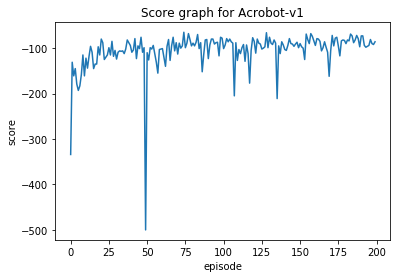

In [77]:
plt.title('Score graph for Acrobot-v1')
plt.plot(np.arange(200), score_list[:200])
plt.xlabel('episode')
plt.ylabel('score')
plt.show()